In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from  sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from xgboost import plot_importance
from pyLCA.snowflake import *
import getpass
from statistics import mean
import pickle
from pickle import load
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular
#import scipy.stats as stats
#import pylab 

In [3]:
# input snowflake password
snow_password = getpass.getpass()

········


In [5]:
sf_engine = connect_to_snowflake(user="tom.walker@sainsburys.co.uk", password=snow_password,
                                 schema='sandbox', environment='local')
sf_con = sf_engine.connect()

In [6]:
base_data = pd.read_sql("""select * from CUSTOMER_ANALYTICS.SANDBOX.tw_innovation_day_summarised_results_2
where hg is not null""", sf_con)

In [7]:
prediction_data = pd.read_sql("""select * from CUSTOMER_ANALYTICS.SANDBOX.tw_innovation_day_summarised_results_2
where hg is null""", sf_con)

In [8]:
base_data

,season,match_id,home_team,hg,ag,referee,position_h,prev_ftg_h,prev_ftga_h,prev_htg_h,...,prev_ftg_a,prev_ftga_a,prev_htg_a,prev_htga_a,prev_shots_a,prev_shotsa_a,prev_st_a,prev_sta_a,prev_c_a,prev_ca_a
0,15-16,539,Liverpool,2,2,C Pawson,8,9,6,5,...,6,8,4,3,40,63,14,20,15,25
1,15-16,540,Leicester,2,1,M Clattenburg,0,12,4,4,...,2,5,1,1,72,52,20,20,31,21
2,15-16,541,West Brom,1,2,M Dean,13,6,7,4,...,8,7,3,6,81,54,29,22,40,27
3,15-16,542,Stoke,1,2,R Madley,11,4,2,3,...,9,4,5,2,73,75,29,17,38,39
4,15-16,543,Southampton,0,2,K Friend,13,3,6,0,...,7,5,5,1,74,44,31,17,29,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,15-16,575,Arsenal,1,0,A Taylor,0,9,6,6,...,5,4,1,1,39,82,12,28,14,45
1844,15-16,576,Watford,1,2,M Atkinson,10,9,4,6,...,7,6,4,4,84,50,29,23,37,12
1845,15-16,577,West Brom,2,1,L Mason,11,5,6,2,...,9,5,6,2,66,71,20,25,18,38
1846,15-16,578,West Ham,2,0,R Madley,5,3,2,1,...,4,7,1,3,92,31,23,14,31,25


In [9]:
def prepare(data):
    print(data.shape)
    data.set_index('match_id',inplace=True)
    data.drop(columns = ['referee','home_team','away_team','season'],inplace=True)
        # one hot encoding the categorical features

    #One hot encode categorical data
    #data = pd.get_dummies(data, 
                       # columns=['referee'], 
                       # prefix=['referee'])
    
    data.fillna(0,inplace=True)

    return data

In [10]:
# clean data 
base_data = prepare(base_data)

(1848, 29)


## Checking skewness of data

In [ ]:
base_data.skew()

In [ ]:
sns.histplot(data=base_data['hg'])

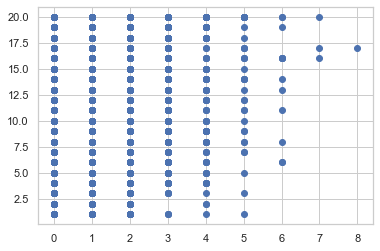

In [9]:
plt.scatter(base_data['hg'], base_data['position_a'])

In [11]:
def split_vars(df, target_name,features=None):
    
    if features == None:
        x_cols = list(df.columns)
        x_cols.remove(target_name)

        X = df[x_cols]
        y = df[[target_name]]
    
        return X,y
    
    else:
        X = df[features]
        y = df[[target_name]]

        return X,y

In [12]:

def k_best_features(X,y,n):

    # SelectKBest class to get top 20 best features
    bestfeatures = SelectKBest(score_func=f_classif, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  
    print('Best features are:')
    print(featureScores.nlargest(n,'Score').head(20))
    
    # set X only to top 20 columns and continue to remove features
    choosen_features = featureScores.nlargest(n,'Score').Specs
    columns = list(choosen_features)
    X = X[columns]
    
    return X

In [13]:
# remove features with corrleation >80% - remove the lower ranking feature

def remove_cols(df):
    
    check = True
    for ind,row in df.iteritems():
        
        # get all highly correlated features
        high_corr = row[(row > 0.8) & (row < 1)] 
        
        if not high_corr.empty:
            check=False
            break
            
    if check:
        return df
    else:
        # remove column and row from correlation plot
        df.drop(index= list(high_corr.index), axis=1, inplace=True)
        df.drop(columns = list(high_corr.index), inplace=True)
        remove_cols(df)

    return df

In [14]:
# get features for every customer type
def feature_selection(df,target):
    X,y = split_vars(df, target)
        
    X = k_best_features(X,y,20)
    
    # create correlation matrix
    df_corr = X.corr()

    # remove columns with high correlation
    reduced_df_corr = remove_cols(df_corr)

    # save columns to include in the reduced feature set
    new_features = list(reduced_df_corr.columns)
        
    df = df[new_features]

    return new_features

In [15]:
def split (df, test_size):
    shuffle_df = df.sample(frac=1)

    # Define a size for your train set 
    train_size = int((1-test_size) * len(df))

    # Split your dataset 
    train = shuffle_df[:train_size]
    test = shuffle_df[train_size:]
    
    return train,test

In [16]:

def split_vars(df, target_name,features=None):
    
    if features == None:
        x_cols = list(df.columns)
        x_cols.remove(target_name)

        X = df[x_cols]
        y = df[[target_name]]
    
        return X,y
    
    else:
        X = df[features]
        y = df[[target_name]]

        return X,y


In [17]:
home_data=base_data.drop(columns = 'ag')
away_data=base_data.drop(columns = 'hg')

# Split up into Home Goals and Away Goals

In [ ]:
# Put all the functions here

In [47]:
X_train

,position_h,position_a,prev_st_h,prev_ftg_h,prev_c_h,prev_shotsa_h,prev_st_a,prev_sta_h,prev_htg_h,prev_shotsa_a,prev_ftg_a,prev_ca_h,prev_htg_a,prev_sta_a,prev_ftga_h,prev_ftga_a,prev_ca_a,prev_htga_a
match_id,,,,,,,,,,,,,,,,,,
1746,15,17,9,2,20,58,13,28,2,91,2,23,1,27,9,8,42,6
2084,5,0,34,15,26,42,44,16,8,33,19,17,10,15,3,3,13,0
1782,17,7,11,5,28,68,9,21,1,73,4,36,1,20,6,3,32,1
1986,8,2,16,4,27,52,22,12,1,34,6,29,1,9,2,2,19,0
1099,15,15,17,8,29,74,13,19,3,87,2,39,0,27,7,7,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,13,11,13,4,14,81,16,26,2,84,3,36,3,29,8,8,38,6
276,11,2,15,6,22,56,31,26,3,46,10,28,6,19,7,5,25,2
1343,3,9,33,13,32,33,26,13,6,65,10,19,6,21,4,10,33,5


In [56]:
#Scale X and Y
def scaling_function(X_train, X_test, dtf_train, dtf_test, target):
    ## scale X
    scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    X = scalerX.fit_transform(X_train)
    dtf_scaled= pd.DataFrame(X, index=X_train.index, columns=X_train.columns)
    X2 = scalerX.fit_transform(X_test)
    dtf_test_scaled= pd.DataFrame(X2, index=X_test.index, columns=X_test.columns)
    ## scale Y
    scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    dtf_scaled[target] = scalerY.fit_transform(
                    dtf_train[target].values.reshape(-1,1))
    dtf_test_scaled[target] = scalerY.fit_transform(
                    dtf_test[target].values.reshape(-1,1))
    return dtf_scaled, dtf_test_scaled, scalerX, scalerY

In [19]:
def plot_importances(X,y,feature_names):
    ## call model
    model = ensemble.GradientBoostingRegressor()
    ## Importance
    model.fit(X,y)
    importances = model.feature_importances_
    ## Put in a pandas dtf
    dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
    dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
    dtf_importances = dtf_importances.set_index("VARIABLE")
    
    ## Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
    fig.suptitle("Features Importance", fontsize=20)
    ax[0].title.set_text('variables')
    dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
    ax[0].set(ylabel="")
    ax[1].title.set_text('cumulative')
    dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
    ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
    plt.xticks(rotation=70)
    plt.grid(axis='both')
    plt.show()

In [20]:
def k_fold_validation(model,X_train,y_train):
    ## K fold validation
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()

In [21]:
def kpis(predicted,y_test):
    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    ## residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return max_true, max_pred, max_error, residuals

In [22]:
def predicted_vs_true(predicted,y_test):
    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2)
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(predicted, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()
    
    ## Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    plt.show()

In [23]:
def residuals_distribution(residuals):
    fig, ax = plt.subplots()
    sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
    ax.grid(True)
    ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()

In [24]:
def predictor(y_test,predicted,number):
    print("True:", "{:,.0f}".format(y_test[number]), "--> Pred:", "{:,.0f}".format(predicted[number]))

In [25]:
def explainer(X_train, reduced_features,model, number):
    explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=reduced_features, class_names="hg", mode="regression")
    explained = explainer.explain_instance(X_test[number], model.predict, num_features=10)
    explained.as_pyplot_figure()

## Home Goals

----------all data----------
Best features are:
            Specs      Score
0      position_h  38.680565
11     position_a  23.373039
7       prev_st_h  16.298956
5    prev_shots_h  13.095430
1      prev_ftg_h  12.548733
9        prev_c_h  12.332541
6   prev_shotsa_h  12.035221
18      prev_st_a   8.444009
8      prev_sta_h   7.259099
3      prev_htg_h   7.204986
17  prev_shotsa_a   6.777979
12     prev_ftg_a   6.533249
10      prev_ca_h   6.177848
16   prev_shots_a   5.487449
14     prev_htg_a   4.955184
19     prev_sta_a   4.558217
2     prev_ftga_h   4.134608
13    prev_ftga_a   3.737159
21      prev_ca_a   3.652185
15    prev_htga_a   3.160425


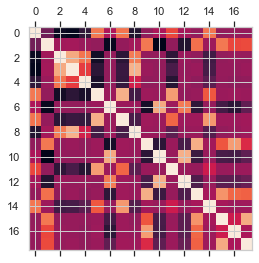

In [26]:
# create new redcued dataset without highly correlated features
print('----------all data----------')
reduced_features = feature_selection(home_data,'hg')

plt.matshow(base_data[reduced_features].corr())
plt.show()

In [27]:
dtf_train,dtf_test = split(home_data,0.2)

In [68]:
X_train, y_train = split_vars(dtf_train, 'hg',reduced_features)
X_test, y_test = split_vars(dtf_test, 'hg',reduced_features)

In [69]:
#Scale the dataframe
dtf_scaled, dtf_test_scaled, scalerX, scalerY_home=scaling_function(X_train,X_test,dtf_train, dtf_test,'hg')

In [70]:
X = X_train.values
y = y_train["hg"].values
feature_names = X_train.columns.tolist()

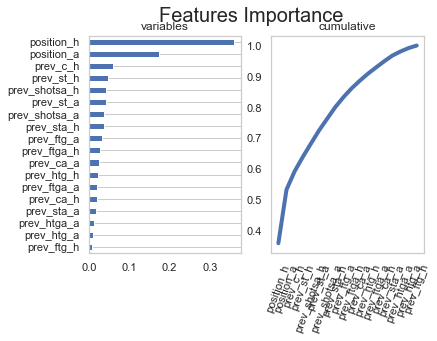

In [71]:
plot_importances(X,y,feature_names)

In [72]:
X_train = dtf_train[reduced_features].values
y_train = dtf_train["hg"].values
X_test = dtf_test[reduced_features].values
y_test = dtf_test["hg"].values

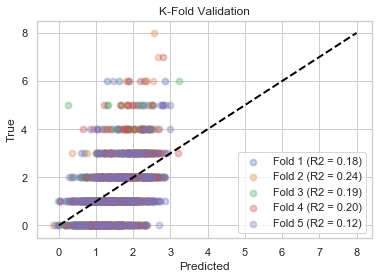

In [73]:
## call model
model_home = linear_model.LinearRegression()
k_fold_validation(model_home,X_train,y_train)

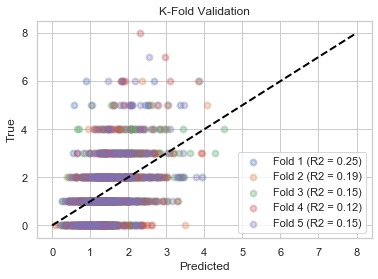

In [74]:
## call model
model_home2 = ensemble.GradientBoostingRegressor()
k_fold_validation(model_home2,X_train,y_train)

In [75]:
## train
model_home.fit(X, y)
## test
predicted_home = model_home.predict(X_test)

In [65]:
#predicted_home = scalerY_home.inverse_transform( 
                  #predicted_home.reshape(-1,1) ).reshape(-1)

In [76]:
max_true, max_pred, max_error, residuals=kpis(predicted_home,y_test)

R2 (explained variance): 0.2
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.74
Mean Absolute Error (Σ|y-pred|/n): 1
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 1
Max Error: 5


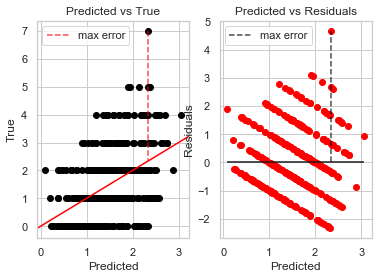

In [77]:
predicted_vs_true(predicted_home,y_test)

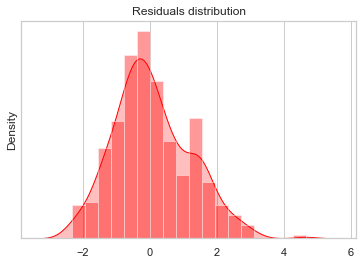

In [78]:
residuals_distribution(residuals)

In [79]:
predictor(y_test,predicted_home,1)

True: 4 --> Pred: 2


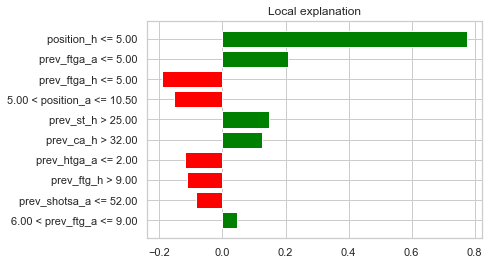

In [80]:
explainer(X_train, reduced_features,model_home,1)

## Away Goals

----------all data----------
Best features are:
            Specs      Score
11     position_a  37.899360
0      position_h  30.687327
16   prev_shots_a  22.822870
18      prev_st_a  20.128676
20       prev_c_a  14.859623
12     prev_ftg_a  12.984700
17  prev_shotsa_a  12.067191
21      prev_ca_a   8.511563
7       prev_st_h   6.699340
13    prev_ftga_a   6.401067
19     prev_sta_a   5.917783
6   prev_shotsa_h   5.883411
1      prev_ftg_h   5.663683
3      prev_htg_h   5.184179
5    prev_shots_h   5.033776
14     prev_htg_a   4.988374
8      prev_sta_h   4.752238
10      prev_ca_h   4.510211
15    prev_htga_a   4.334619
2     prev_ftga_h   3.065292


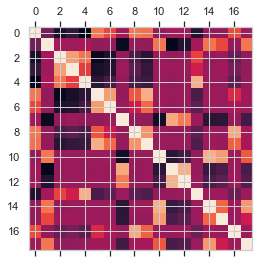

In [83]:
# create new redcued dataset without highly correlated features
print('----------all data----------')
reduced_features = feature_selection(away_data,'ag')

plt.matshow(base_data[reduced_features].corr())
plt.show()

In [84]:
dtf_train,dtf_test = split(away_data,0.2)

In [85]:
X_train, y_train = split_vars(dtf_train, 'ag',reduced_features)
X_test, y_test = split_vars(dtf_test, 'ag',reduced_features)

In [87]:
#Scale the dataframe
dtf_scaled, dtf_test_scaled, scalerX, scalerY_away=scaling_function(X_train,X_test,dtf_train,dtf_test,'ag')

In [88]:
X = X_train.values
y = y_train["ag"].values
feature_names = X_train.columns.tolist()

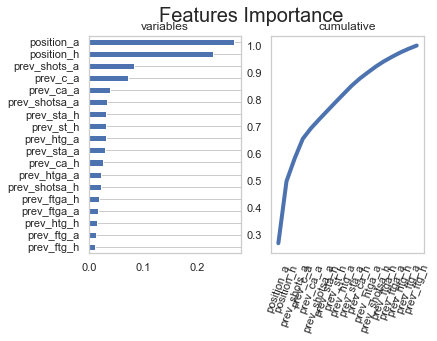

In [89]:
plot_importances(X,y,feature_names)

In [90]:
X_train = dtf_scaled[reduced_features].values
y_train = dtf_scaled["ag"].values
X_test = dtf_test[reduced_features].values
y_test = dtf_test["ag"].values

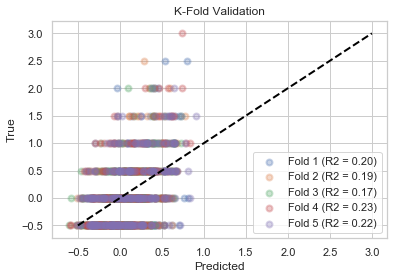

In [91]:
## call model
model_away = linear_model.LinearRegression()
k_fold_validation(model_away,X_train,y_train)

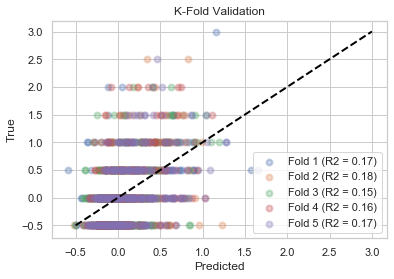

In [92]:
## call model
model_away2 = ensemble.GradientBoostingRegressor()
k_fold_validation(model_away2,X_train,y_train)

In [93]:
## train
model_away.fit(X, y)
## test
predicted_away = model_away.predict(X_test)

In [177]:
#predicted_away = scalerY_away.inverse_transform( 
                 # predicted_away.reshape(-1,1) ).reshape(-1)

In [94]:
max_true, max_pred, max_error, residuals=kpis(predicted_away,y_test)

R2 (explained variance): 0.21
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.92
Mean Absolute Error (Σ|y-pred|/n): 1
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 1
Max Error: 3


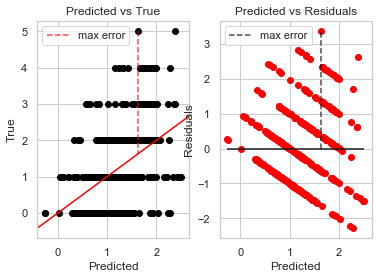

In [95]:
predicted_vs_true(predicted_away,y_test)

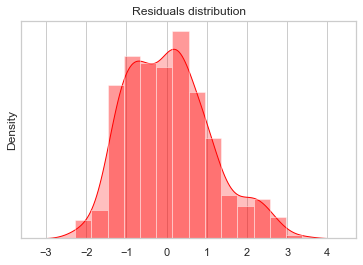

In [96]:
residuals_distribution(residuals)

In [97]:
predictor(y_test,predicted_away,1)

True: 0 --> Pred: 0


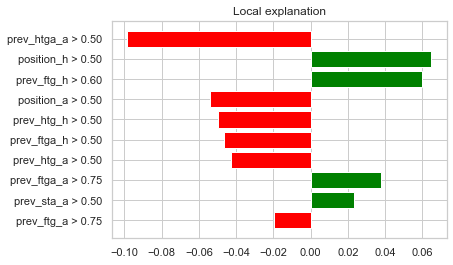

In [98]:
explainer(X_train, reduced_features,model_away,1)

# Predict this weekend's fixtures

In [183]:
prediction_data

,season,match_id,home_team,hg,ag,referee,position_h,prev_ftg_h,prev_ftga_h,prev_htg_h,...,prev_ftg_a,prev_ftga_a,prev_htg_a,prev_htga_a,prev_shots_a,prev_shotsa_a,prev_st_a,prev_sta_a,prev_c_a,prev_ca_a
0,21-22,2149,Southampton,None,None,None,7,8,7,2,...,7,9,3,1,40,91,10,31,21,40
1,21-22,2150,Leeds,None,None,None,10,5,17,2,...,5,10,2,4,49,85,20,32,19,34
2,21-22,2151,Brentford,None,None,None,5,3,9,0,...,7,3,3,2,71,64,18,16,27,23
3,21-22,2152,Brighton,None,None,None,6,4,7,1,...,6,7,4,4,64,62,18,21,27,34
4,21-22,2153,Crystal Palace,None,None,None,4,6,6,2,...,5,2,2,2,55,68,18,17,18,36
5,21-22,2154,Man United,None,None,None,2,9,4,4,...,2,7,1,3,42,60,12,17,28,28
6,21-22,2155,Everton,None,None,None,16,5,8,3,...,10,4,3,2,89,31,31,14,51,10
7,21-22,2156,West Ham,None,None,None,3,6,7,3,...,7,5,4,2,50,83,18,22,24,32
8,21-22,2157,Burnley,None,None,None,15,5,2,2,...,6,10,3,4,64,82,19,32,28,31


In [99]:
predicted_home = model_home.predict(prediction_data[reduced_features])
predicted_away = model_away.predict(prediction_data[reduced_features])
#predicted_home = scalerY_home.inverse_transform( 
                #  predicted_home.reshape(-1,1) ).reshape(-1)
#predicted_away = scalerY_away.inverse_transform( 
                 # predicted_away.reshape(-1,1) ).reshape(-1)

In [107]:
predicted_home2=pd.DataFrame(predicted_home,columns=['home_score'])
predicted_away2=pd.DataFrame(predicted_away,columns=['away_score'])

In [193]:
pd.concat([prediction_data[['home_team']], predicted_home2 ,
           prediction_data[['away_team']], predicted_away2], axis=1, join="outer")

,home_team,home_score,away_team,away_score
0,Southampton,1.548227,Norwich,0.465031
1,Leeds,2.066772,Tottenham,0.780241
2,Brentford,1.680234,Newcastle,0.701151
3,Brighton,1.838528,Aston Villa,0.872950
4,Crystal Palace,0.854257,Burnley,0.263936
5,Man United,1.277393,Watford,0.446264
6,Everton,3.367670,Man City,2.340852
7,West Ham,2.360178,Wolves,0.798031
8,Burnley,2.760147,Leicester,1.601818


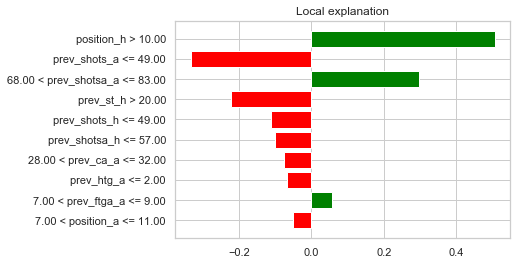

In [194]:
explainer(prediction_data[reduced_features].values, reduced_features,model_home,0)